# FSI of a neutrally-buoyant 1d plate swimming in quiescent viscous flow

In [2]:
using Revise
using BSON: @save, @load

using Plots
pyplot()
default(grid = false)

In [ ]:
using Pkg
Pkg.activate("../..")
using FSI

In [3]:
filename = "2dSwim_unitmass_plate";

## <span style="color:blue"> Set up rigid body with Dyn3d.jl

#### Include any joint-body setup script from Dyn3d

In [4]:
# problem dimension
ndim = 2
# numerical params
tf = 4
dt = 1e-3
scheme = "Liska"
st = 5
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 3
config_body = ConfigBody(nbody, 4, [0. 0.; 1. 0.; 1. 1.0; 0. 1.0], 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.1;

#### set the first passive planar joint with no stiff and damp

In [5]:
dof₁ = Vector{Dof}(undef,3)
[dof₁[i] = Dof(i+2, "passive", 0., 0., Motions()) for i = 1:3]
config_joints[1] = ConfigJoint(njoint, "planar",
    [0.,0.,0.,0.6,2.0,0.], zeros(Float64,6), 0, dof₁, [0.0,0.0,0.0]);

#### set the second active joint with oscillatory motion

In [6]:
motion₂ = Motions("oscillatory", [-1.0, 1.0/(2*π), -π/2])
dof₂ = Dof(3, "active", 0., 0., motion₂)
config_joints[2] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   1, [dof₂], [0.]);

#### set the third active joint with oscillatory motion

In [7]:
motion₃ = Motions("oscillatory", [-1.0, 1.0/(2*π), 0.0])
dof₃ = Dof(3, "active", 0., 0., motion₃)
config_joints[3] = ConfigJoint(njoint, "revolute",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   2, [dof₃], [0.]);

#### Build joint-body chain

In [8]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys);

#### Initialize rigid body system state to complete body-joint information

In [9]:
bd, soln₀ = InitSystem!(bd);

#### Initialize u and λ container

In [10]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [11]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

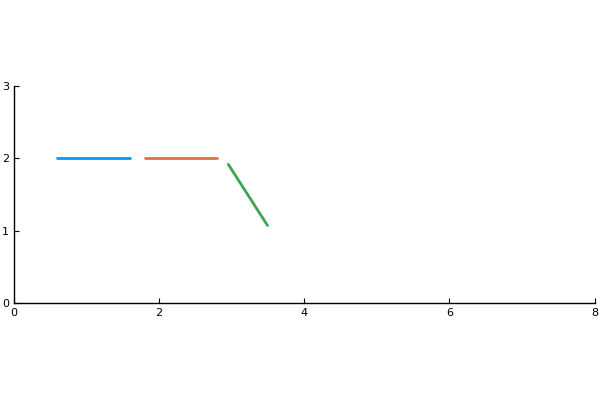

In [12]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,8), ylims=(0,3), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with ViscousFlow.jl</span>

#### Set the flow parameters

In [13]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [14]:
nx = 402; ny = 152;
Ly = 3;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:8.01, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [15]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [16]:
plane = [1,2];

#### Genrate body grid points and get linear velocity on them

In [17]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx, fine=3.0))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [18]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [19]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [20]:
tf = 2500Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

153

## <span style="color:blue"> Create ifherk object </span>

In [21]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=TimeMarching.RK31, bodydim=1)

 20.973504 seconds (67.68 M allocations: 5.227 GiB, 5.10% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [22]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [ ]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
end

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [36]:
contour_levels = range(-5*Δx,stop=5*Δx,length=40)
sample_rate = 5
clims = (-5*Δx,5*Δx)
fps = 25;

#### Get body verts history

In [38]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

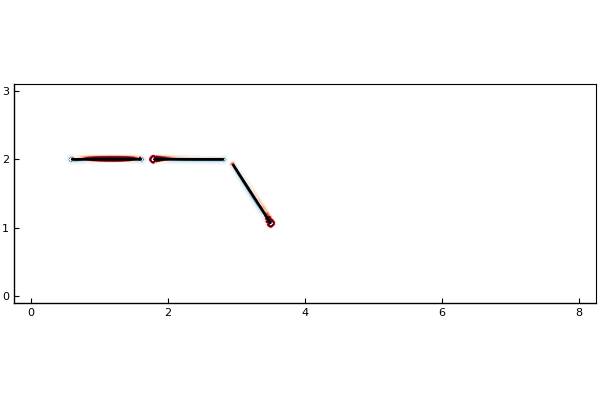

In [39]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_10,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p

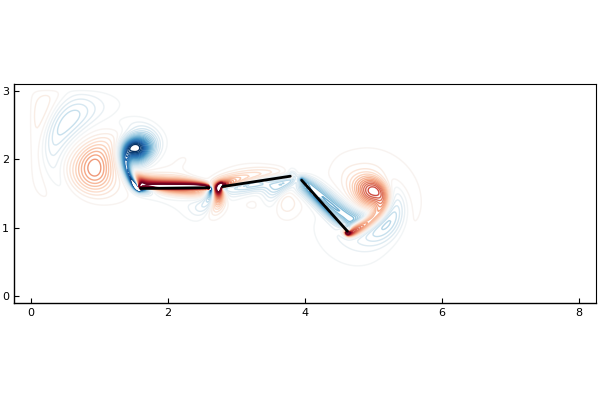

In [40]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_10,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

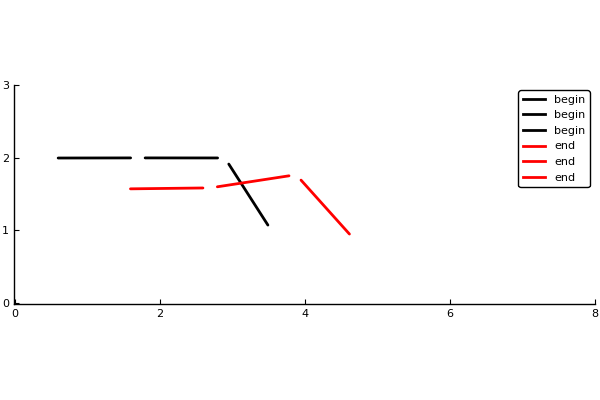

In [41]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### gif with tail

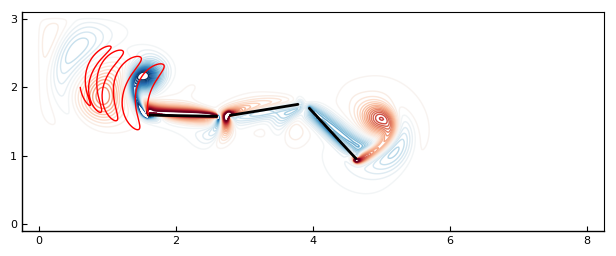

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/2dSwim.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/2dSwim.gif")

In [42]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_10,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
    push!(v1_x,vshist[j][1,2,1])
    push!(v1_y,vshist[j][1,2,2])
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*".gif", fps = fps)

#### gif with 2nd body's center

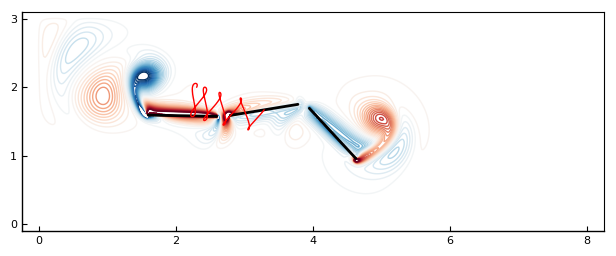

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/2dSwim_center.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/2dSwim_center.gif")

In [43]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_10,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
    push!(v1_x,0.5*(vshist[j][2,2,1]+vshist[j][2,3,1]))
    push!(v1_y,0.5*(vshist[j][2,2,2]+vshist[j][2,3,2]))
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*"_center.gif", fps = fps)

#### Lift and drag coefficient

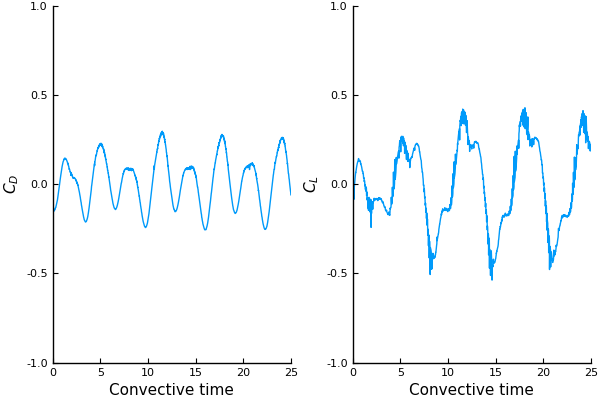

In [44]:
px = plot(thist,2*fx,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

#### position of the central body

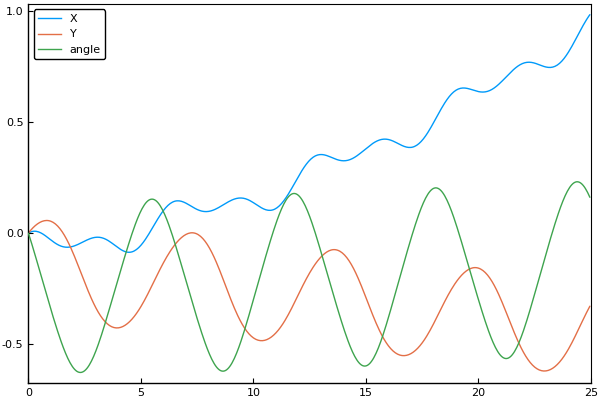

In [45]:
v2_x = []
v2_y = []
α2 = []
t_sampled = []
cnt = 1

for j = 1:sample_rate:length(whist)
    push!(t_sampled,thist[j])
    push!(v2_x,0.5*(vshist[j][2,2,1]+vshist[j][2,3,1])-2.3)
    push!(v2_y,0.5*(vshist[j][2,2,2]+vshist[j][2,3,2])-2)
    push!(α2,atan((v2_y[cnt]+2-vshist[j][2,2,2])/(v2_x[cnt]+2.3-vshist[j][2,2,1])))
    cnt += 1
end

plot(t_sampled,v2_x,label="X", framestyle = :box,xlim=(0,25))
plot!(t_sampled,v2_y,label="Y")
plot!(t_sampled,α2,label="angle")

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .bson file

In [49]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [47]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);